# 1. Import Libraries

In [ ]:
# import system libs
import os

# from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools

# import Deep learning Libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Reshape, Multiply, Add
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, classification_report

# import required ResNeXt50 components
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, DepthwiseConv2D

import warnings
warnings.filterwarnings("ignore")

# 2. Helper Functions


In [ ]:
def train_and_evaluate_model(model, train_gen, valid_gen, test_gen, augmentation_type, epochs=50):
    """
    Train model and visualize results for a specific augmentation strategy
    """
    history = model.fit(
        train_gen,
        validation_data=valid_gen,
        epochs=epochs,
        verbose=1
    )

    # plot and get metrics
    metrics = plot_training_history(history, augmentation_type)

    # get precision and recall
    predicted_classes, true_classes = get_predictions(model, test_gen)
    precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')

    metrics.update({
        'test_precision': precision,
        'test_recall': recall,
        'test_f1': f1
    })

    return history, metrics


In [ ]:
def plot_training_history(history, augmentation_type):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch = {str(index_loss + 1)}'
    acc_label = f'best epoch = {str(index_acc + 1)}'

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title(f'{augmentation_type} Augmentation - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    metrics = {
        'best_val_loss': val_lowest,
        'best_val_loss_epoch': index_loss + 1,
        'best_val_acc': acc_highest,
        'best_val_acc_epoch': index_acc + 1
    }

    return metrics


In [ ]:
def get_predictions(model, generator):
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = generator.classes
    return predicted_classes, true_classes

def evaluate_model(model, generator, class_names):
    predicted_classes, true_classes = get_predictions(model, generator)

    # get detailed metrics
    precision, recall, f1, support = precision_recall_fscore_support(true_classes, predicted_classes)

    # print classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_names))

    return precision, recall, f1, support

In [ ]:
def confusion_matrix_plot(test_gen, y_predict):
  y_pred = np.argmax(y_predict, axis=1)

  # get class indices and labels
  class_indices = test_gen.class_indices
  classes = list(class_indices.keys())

  # compute confusion matrix
  cm = confusion_matrix(test_gen.classes, y_pred)

  plt.figure(figsize=(10, 10))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.colorbar()

  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  threshold = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(
          j, i, f"{cm[i, j]}",
          horizontalalignment='center',
          color='white' if cm[i, j] > threshold else 'black'
      )

  plt.tight_layout()
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.show()

# 3. Load Data

## 3.1 Loading from Kaggle

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')

print('Data source import complete.')


100%|██████████| 1.76G/1.76G [00:23<00:00, 81.5MB/s]

Extracting files...


Data source import complete.


In [ ]:
print(andrewmvd_lung_and_colon_cancer_histopathological_images_path)

/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1


In [ ]:
print(os.listdir(andrewmvd_lung_and_colon_cancer_histopathological_images_path))

['lung_colon_image_set']


## 3.2 Joining Images

In [ ]:
data_dir = '/root/.cache/kagglehub/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/versions/1/lung_colon_image_set'

file_paths = []
labels = []

folders = os.listdir(data_dir)

for folder in folders:
    sub_folder_path = os.path.join(data_dir, folder)
    sub_folder = os.listdir(sub_folder_path)

    for sfolder in sub_folder:
        s_sub_folder_path = os.path.join(sub_folder_path, sfolder)
        file_list = os.listdir(s_sub_folder_path)

        for file in file_list:
            fpath = os.path.join(s_sub_folder_path, file)

            file_paths.append(fpath)
            labels.append(sfolder)


FSeries = pd.Series(file_paths, name='filepaths')
LSeries = pd.Series(labels, name='labels')

df = pd.concat([FSeries, LSeries], axis=1)

## 3.3 Split Data

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])

valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

# 4. Preprocessing

## 4.1 Helper Function

In [ ]:
# Function to create data generators for each augmentation pipeline
def create_data_generators(train_df, valid_df, test_df, augmentation_pipeline):
    train_generator = augmentation_pipeline.flow_from_dataframe(
        dataframe=train_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    # Validation and test generators use only rescaling
    valid_test_generator = ImageDataGenerator(rescale=1./255)

    valid_generator = valid_test_generator.flow_from_dataframe(
        dataframe=valid_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = valid_test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='filepaths',
        y_col='labels',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, valid_generator, test_generator

## 4.2 Data Augmentation

In [ ]:
# Define image size and batch size
IMG_SIZE = 224  # Standard size for many CNN architectures
BATCH_SIZE = 32

### 4.2.1 Basic Augmentation

In [ ]:
# Basic Augmentation Pipeline
# Focuses on basic geometric transformations
basic_augmentation = ImageDataGenerator(
    rescale=1./255
)

# Create generators for each augmentation pipeline
basic_train_gen, basic_valid_gen, basic_test_gen = create_data_generators(
    train_df, valid_df, test_df, basic_augmentation)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.2 Moderate Augmentation

In [ ]:
# Moderate Augmentation Pipeline
# Adds intensity transformations while preserving tissue characteristics
moderate_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

moderate_train_gen, moderate_valid_gen, moderate_test_gen = create_data_generators(
    train_df, valid_df, test_df, moderate_augmentation)


Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


### 4.2.3 Advanced Augmentation

In [ ]:
# Advanced Augmentation Pipeline
# Includes color transformations suitable for histopathology
advanced_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=3,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True
)

advanced_train_gen, advanced_valid_gen, advanced_test_gen = create_data_generators(
    train_df, valid_df, test_df, advanced_augmentation
)

Found 17500 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.
Found 3750 validated image filenames belonging to 5 classes.


# 5. Model Initialization

5.1 Create ResNext Architecture

In [ ]:
def grouped_convolution(x, filters, kernel_size, strides, groups):
    # split input channels into groups
    group_list = []
    input_channels = x.shape[-1] // groups

    for i in range(groups):
        # apply convolution separately for each individual group
        group = Conv2D(filters // groups, kernel_size, strides=strides, padding='same')(x[..., i * input_channels:(i + 1) * input_channels])
        group_list.append(group)

    return Concatenate()(group_list)

In [ ]:
def resnext_block(x, filters, strides=1, groups=32):
    shortcut = x  # shortcut connection

    x = Conv2D(filters, (1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # group convolution layer
    x = grouped_convolution(x, filters, (3, 3), strides=strides, groups=groups)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters * 2, (1, 1), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if shortcut.shape[-1] != x.shape[-1]:   # adjust shortcut if necessary
        shortcut = Conv2D(filters * 2, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # adding the shortcut connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

 ## 5.1 ResNext Model


In [ ]:
def create_model():
  img_size = (224, 224)
  channels = 3
  img_shape = (img_size[0], img_size[1], channels)
  class_count = len(list(basic_train_gen.class_indices.keys()))

  inputs = Input(shape=img_shape)
  x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

  x = resnext_block(x, 128, strides=1)
  x = resnext_block(x, 256, strides=2)
  x = resnext_block(x, 512, strides=2)
  x = resnext_block(x, 1024, strides=2)

  x = GlobalAveragePooling2D()(x)
  outputs = Dense(class_count, activation='softmax')(x)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()

  return model

## 5.2 Model Training

### 5.2.1 Training Basic Augmentation

In [ ]:
model_basic = create_model()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 112, 112, 64)   │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 112, 112, 64)   │            256 │ conv2d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 112, 112, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 56, 56, 128)    │          8,320 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 128)    │            512 │ conv2d_35[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 56, 56, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_32 (GetItem)     │ (None, 56, 56, 4)      │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_33 (GetItem)     │ (None, 56, 56, 4)      │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_34 (GetItem)     │ (None, 56, 56, 4)      │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_35 (GetItem)     │ (None, 56, 56, 4)      │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_36 (GetItem)     │ (None, 56, 56, 4)      │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_37 (GetItem)     │ (None, 56, 56, 4)      │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_38 (GetItem)     │ (None, 56, 56, 4)      │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_39 (GetItem)     │ (None, 56, 56, 4)      │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_40 (GetItem)     │ (None, 56, 56, 4)      │              0 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_41 (GetItem)

 Total params: 7,407,877 (28.26 MB)

 Trainable params: 7,384,709 (28.17 MB)

 Non-trainable params: 23,168 (90.50 KB)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 253s 305ms/step - accuracy: 0.8537 - loss: 0.3944 - val_accuracy: 0.7083 - val_loss: 1.1940
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 120s 220ms/step - accuracy: 0.9548 - loss: 0.1151 - val_accuracy: 0.8987 - val_loss: 0.2744
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 122s 223ms/step - accuracy: 0.9786 - loss: 0.0587 - val_accuracy: 0.5789 - val_loss: 4.0662
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 126s 230ms/step - accuracy: 0.9867 - loss: 0.0396 - val_accuracy: 0.9432 - val_loss: 0.1413
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 123s 225ms/step - accuracy: 0.9913 - loss: 0.0258 - val_accuracy: 0.6392 - val_loss: 2.2429
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 121s 221ms/step - accuracy: 0.9911 - loss: 0.0262 - val_accuracy: 0.6011 - val_loss: 3.9897
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 122s 224ms/step - accuracy: 0.9966 - loss: 0.0126 - val_accuracy: 0.8816 - val_loss: 0.4829
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 121s 222ms/step - accuracy: 0.9968 -

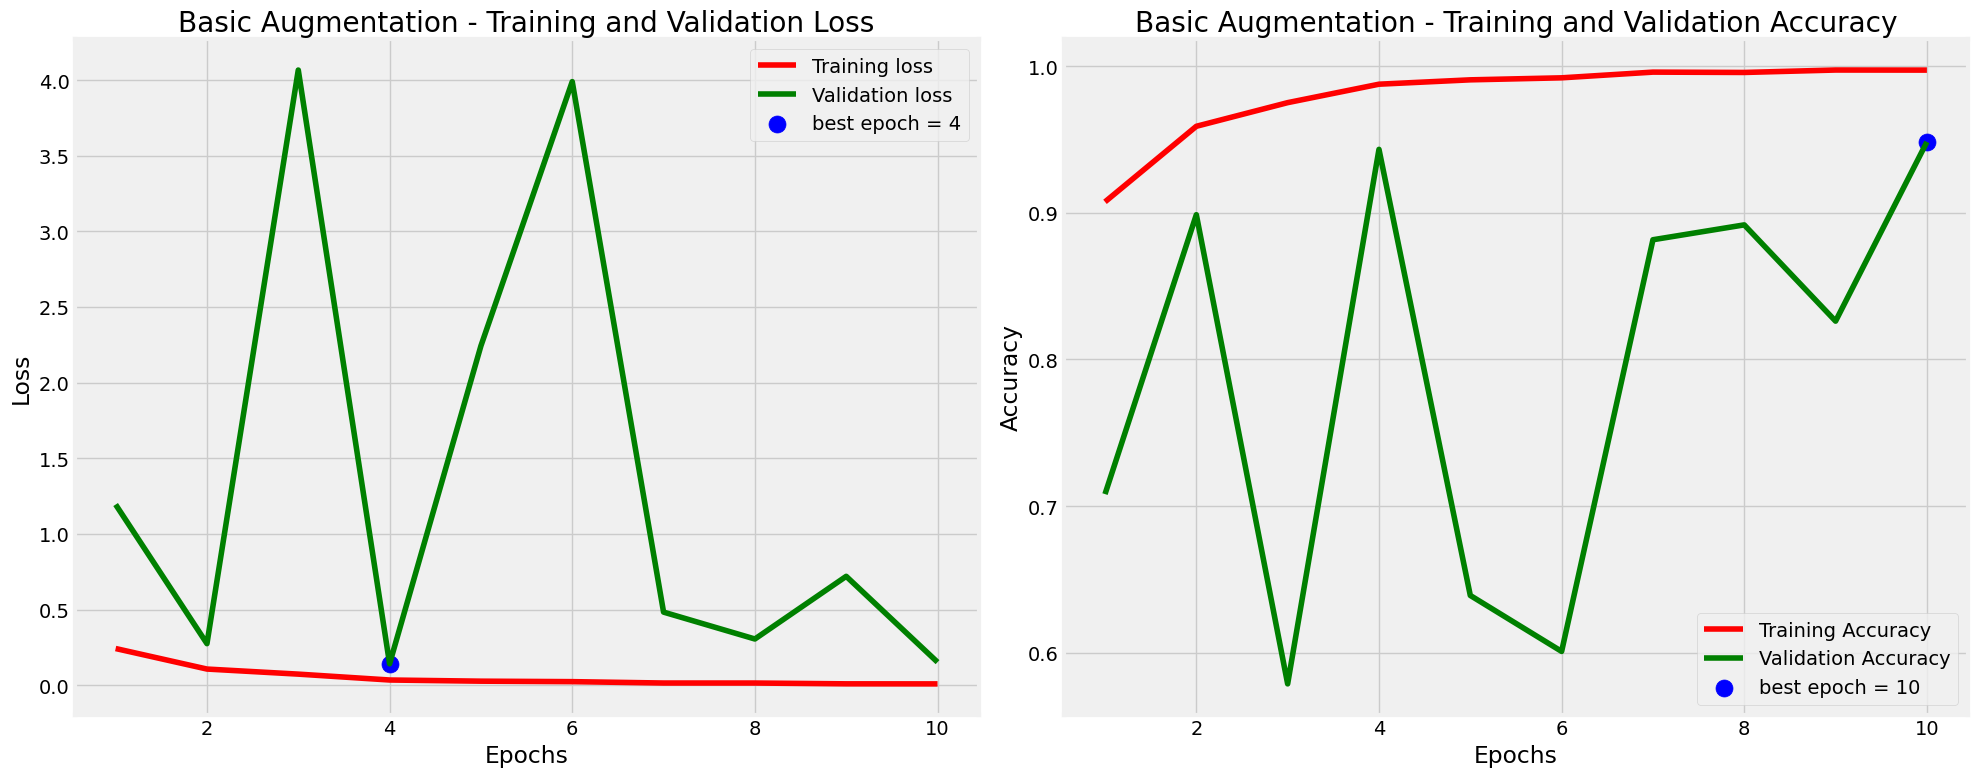

118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 171ms/step


In [ ]:
hist_basic, metrics_basic = train_and_evaluate_model(model_basic, basic_train_gen, basic_valid_gen, basic_test_gen, 'Basic', epochs=10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step


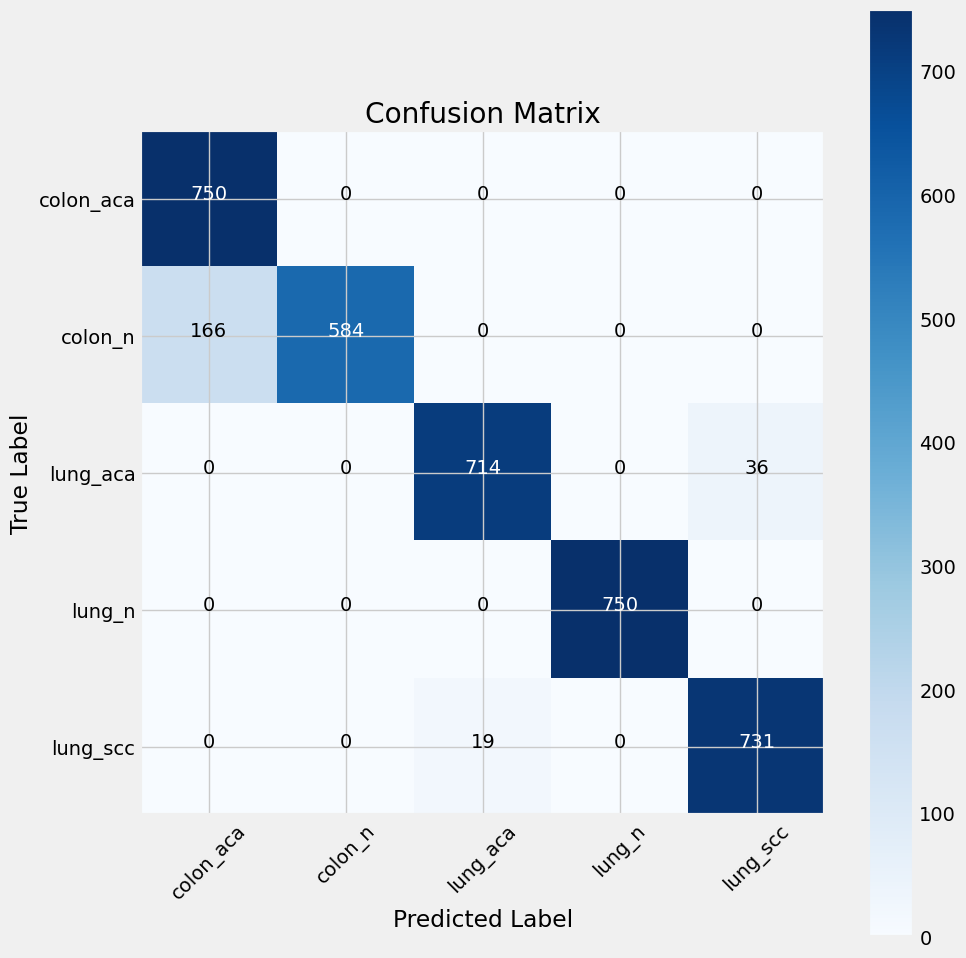

In [ ]:
y_predict_basic = model_basic.predict(basic_test_gen)
confusion_matrix_plot(basic_test_gen, y_predict_basic)

### 5.2.2 Training Moderate Augmentation

In [ ]:
model_moderate = create_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_175 (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 112, 112, 64)   │            256 │ conv2d_175[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 56, 56, 64)     │              0 │ activation_15[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_176 (Conv2D)       │ (None, 56, 56, 128)    │          8,320 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 56, 56, 128)    │            512 │ conv2d_176[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 56, 56, 128)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_160 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_161 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_162 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_163 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_164 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_165 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_166 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_167 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_168 (GetItem

 Total params: 7,407,877 (28.26 MB)

 Trainable params: 7,384,709 (28.17 MB)

 Non-trainable params: 23,168 (90.50 KB)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 381s 569ms/step - accuracy: 0.8650 - loss: 0.3938 - val_accuracy: 0.4021 - val_loss: 7.2869
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 285s 520ms/step - accuracy: 0.9507 - loss: 0.1256 - val_accuracy: 0.7013 - val_loss: 4.2855
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 291s 531ms/step - accuracy: 0.9651 - loss: 0.0917 - val_accuracy: 0.6680 - val_loss: 3.5823
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 287s 524ms/step - accuracy: 0.9759 - loss: 0.0644 - val_accuracy: 0.6320 - val_loss: 7.5202
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 286s 523ms/step - accuracy: 0.9768 - loss: 0.0598 - val_accuracy: 0.9027 - val_loss: 0.3108
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 286s 523ms/step - accuracy: 0.9846 - loss: 0.0391 - val_accuracy: 0.9243 - val_loss: 0.2384
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 324s 527ms/step - accuracy: 0.9849 - loss: 0.0412 - val_accuracy: 0.9629 - val_loss: 0.1160
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 291s 532ms/step - accuracy: 0.9895 -

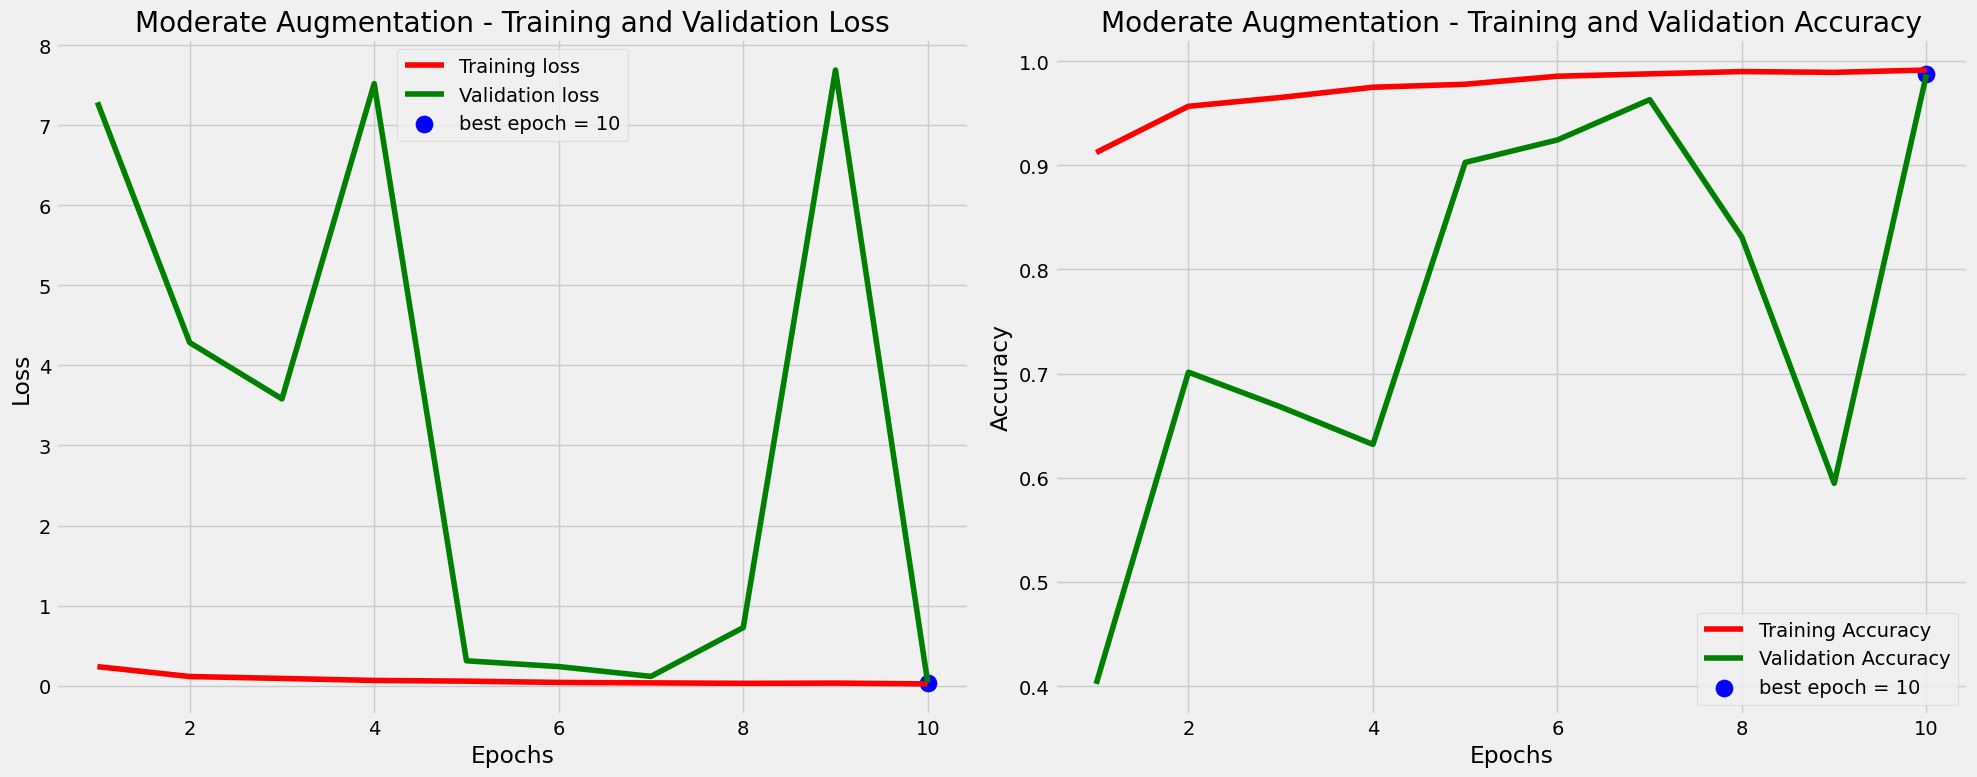

118/118 ━━━━━━━━━━━━━━━━━━━━ 24s 165ms/step


In [ ]:
hist_moderate, metrics_moderate = train_and_evaluate_model(model_moderate, moderate_train_gen, moderate_valid_gen, moderate_test_gen, "Moderate", epochs= 10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step


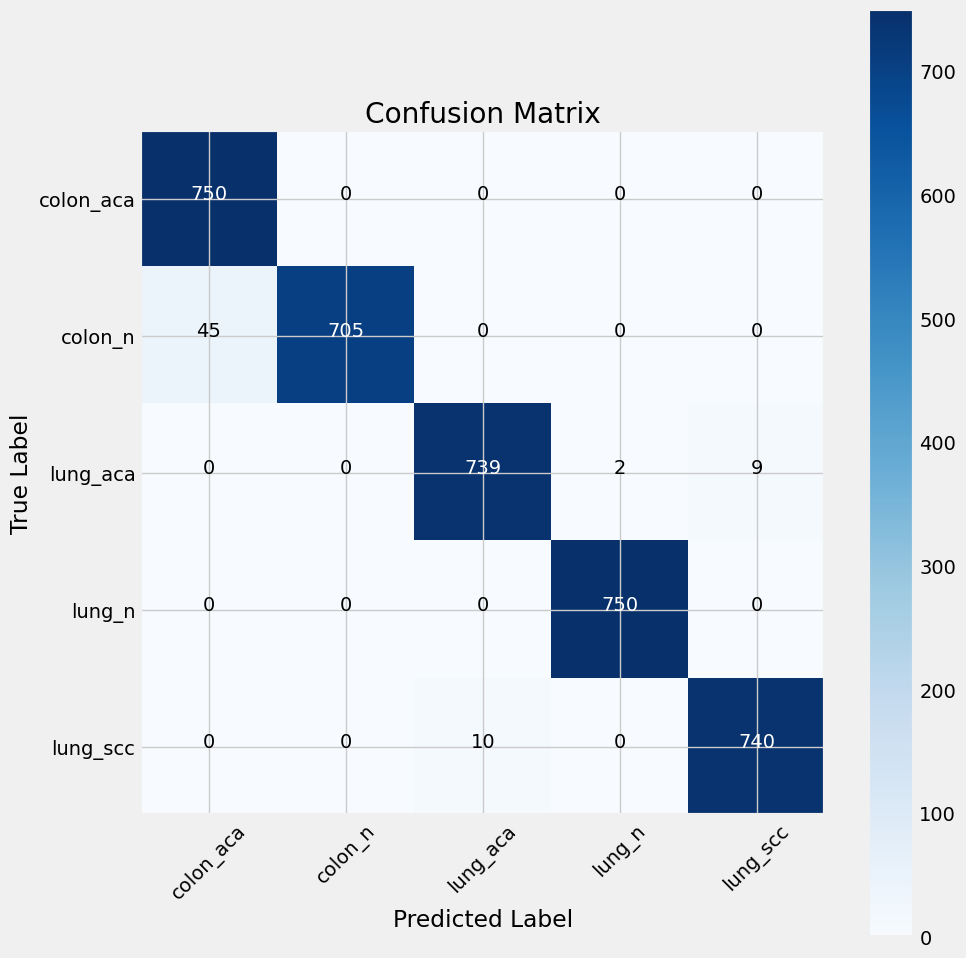

In [ ]:
y_predict_moderate = model_moderate.predict(moderate_test_gen)
confusion_matrix_plot(moderate_test_gen, y_predict_moderate)

### 5.2.3 Training Advanced Augmentation

In [ ]:
model_advanced = create_model()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_316 (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 112, 112, 64)   │            256 │ conv2d_316[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_28             │ (None, 112, 112, 64)   │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 56, 56, 64)     │              0 │ activation_28[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_317 (Conv2D)       │ (None, 56, 56, 128)    │          8,320 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 56, 56, 128)    │            512 │ conv2d_317[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_29             │ (None, 56, 56, 128)    │              0 │ batch_normalization_3… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_288 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_289 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_290 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_291 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_292 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_293 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_294 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_295 (GetItem)    │ (None, 56, 56, 4)      │              0 │ activation_29[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_296 (GetItem

 Total params: 7,407,877 (28.26 MB)

 Trainable params: 7,384,709 (28.17 MB)

 Non-trainable params: 23,168 (90.50 KB)

Epoch 1/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 381s 573ms/step - accuracy: 0.8577 - loss: 0.4030 - val_accuracy: 0.7312 - val_loss: 3.3230
Epoch 2/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 279s 510ms/step - accuracy: 0.9496 - loss: 0.1264 - val_accuracy: 0.4923 - val_loss: 4.4514
Epoch 3/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 283s 518ms/step - accuracy: 0.9597 - loss: 0.1007 - val_accuracy: 0.4493 - val_loss: 6.8165
Epoch 4/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 281s 514ms/step - accuracy: 0.9704 - loss: 0.0750 - val_accuracy: 0.8829 - val_loss: 0.5325
Epoch 5/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 286s 524ms/step - accuracy: 0.9755 - loss: 0.0594 - val_accuracy: 0.5467 - val_loss: 4.8815
Epoch 6/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 277s 506ms/step - accuracy: 0.9780 - loss: 0.0574 - val_accuracy: 0.8491 - val_loss: 0.5028
Epoch 7/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 284s 519ms/step - accuracy: 0.9842 - loss: 0.0421 - val_accuracy: 0.7363 - val_loss: 3.4254
Epoch 8/10
547/547 ━━━━━━━━━━━━━━━━━━━━ 282s 515ms/step - accuracy: 0.9863 -

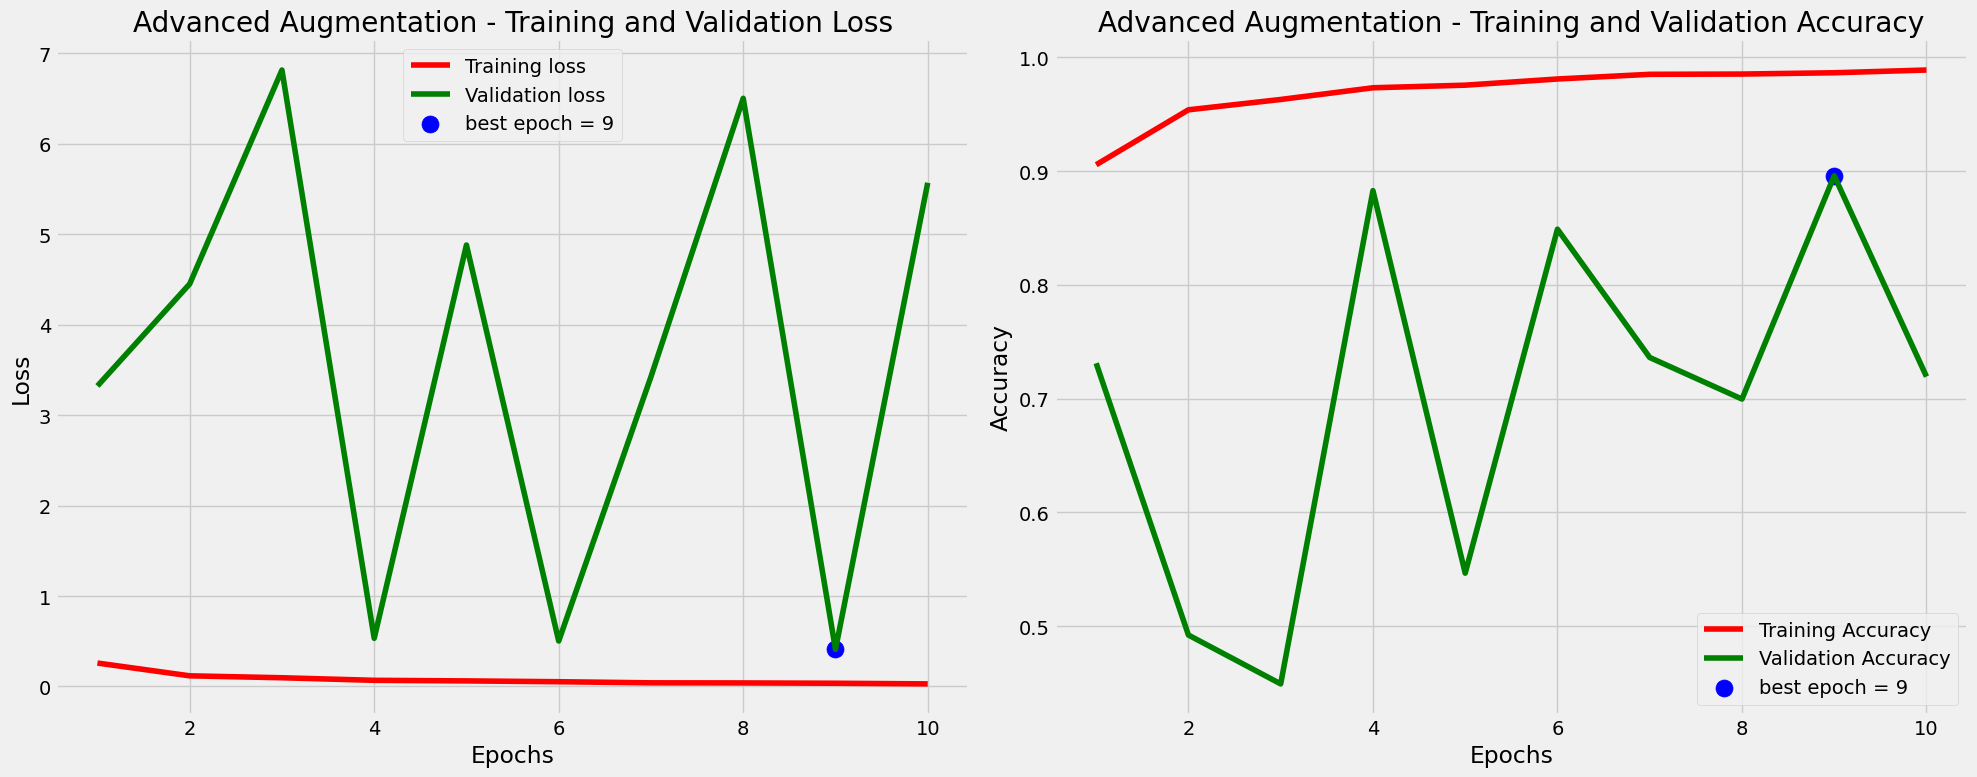

118/118 ━━━━━━━━━━━━━━━━━━━━ 23s 158ms/step


In [ ]:
hist_advanced, metrics_advanced = train_and_evaluate_model(model_advanced, advanced_train_gen, advanced_valid_gen, advanced_test_gen, "Advanced", epochs=10)

118/118 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step


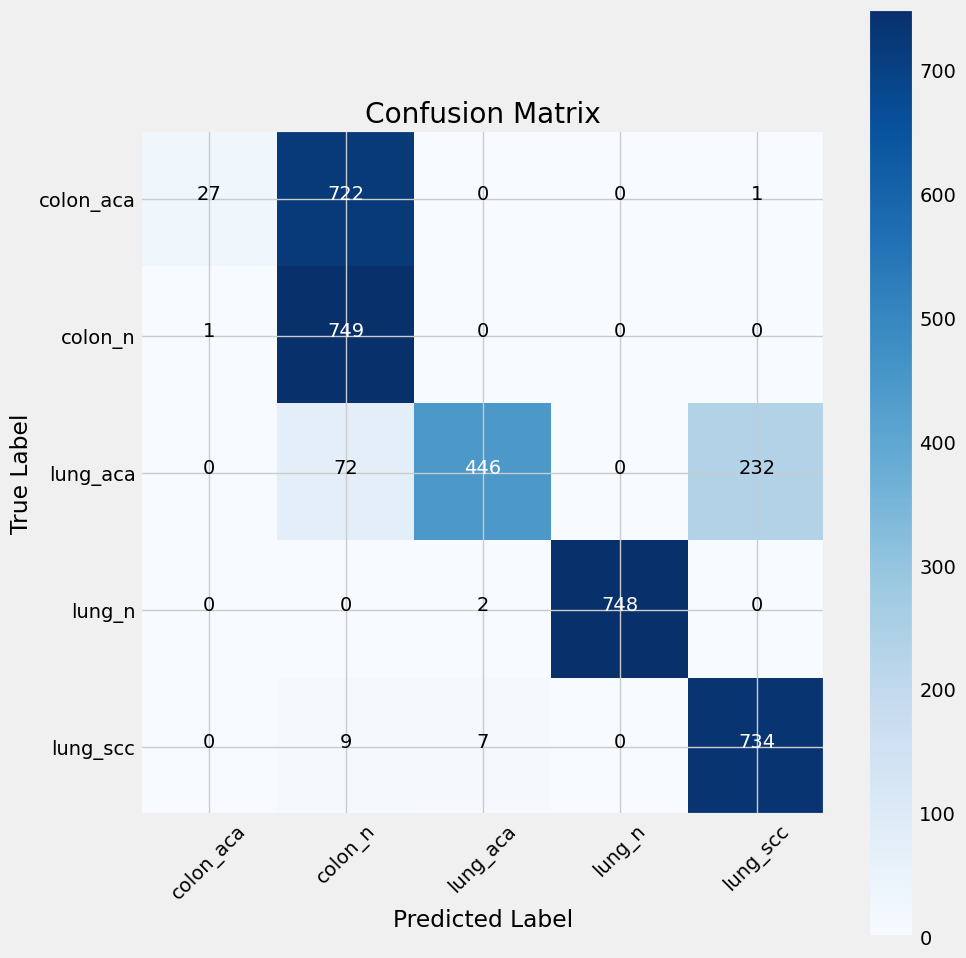

In [ ]:
y_predict_advanced = model_advanced.predict(advanced_test_gen)
confusion_matrix_plot(advanced_test_gen, y_predict_advanced)

# 6. Evaluation

In [ ]:
print(metrics_basic)

{'best_val_loss': 0.14131249487400055, 'best_val_loss_epoch': np.int64(4), 'best_val_acc': 0.9482666850090027, 'best_val_acc_epoch': np.int64(10), 'test_precision': 0.9491840609439093, 'test_recall': 0.9410666666666667, 'test_f1': 0.9405159218291157}


In [ ]:
print(metrics_moderate)

{'best_val_loss': 0.037059247493743896, 'best_val_loss_epoch': np.int64(10), 'best_val_acc': 0.9872000217437744, 'best_val_acc_epoch': np.int64(10), 'test_precision': 0.9830738991477461, 'test_recall': 0.9824, 'test_f1': 0.9823859874258497}


In [ ]:
print(metrics_advanced)

{'best_val_loss': 0.4093087911605835, 'best_val_loss_epoch': np.int64(9), 'best_val_acc': 0.8960000276565552, 'best_val_acc_epoch': np.int64(9), 'test_precision': 0.8372314382437358, 'test_recall': 0.7210666666666666, 'test_f1': 0.6628081386821083}
